In [2]:
import os
import cv2
import json
import string
import csv
import pickle
import timm
import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision.models.detection.image_list import ImageList
from transformers import DetrForObjectDetection, DetrFeatureExtractor

data_dir = os.path.join('dataset')
working_dir = os.path.join('working')
images_dir = os.path.join(data_dir,'Images')
captions_dir = os.path.join(data_dir,'captions.txt')

In [3]:
import torch

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU devices available.")
# *********************
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Device 0: NVIDIA GeForce GTX 1660 SUPER
Using device: cuda


In [4]:
import gensim

pretrained_embeddings_path = "GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embeddings_path, 
binary=True)

In [5]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec


# # Example text data
# documents = ["This is the first sentence.", "Here is another one.", "And a third sentence."]

# # Preprocess text
# processed_docs = [simple_preprocess(doc) for doc in documents]



In [6]:
# processed_docs

In [7]:
# for flickr8k
def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as file:
        reader = csv.reader(file) 
        for row in reader:
            if len(row) != 2:
                print(f"Skipping malformed line: {row[:50]}...")  
                continue
            image_id, caption = row
            image_id = image_id.split('.')[0]  
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    
    return captions
captions = load_captions(captions_dir)

In [8]:
# # for flickr30k
# def load_captions(filepath):
#     captions = {}
#     # Adding encoding parameter to handle potential encoding issues
#     with open(filepath, 'r', encoding='utf-8', errors='replace') as file:
#         reader = csv.reader(file) 
#         for row in reader:
#             if len(row) != 2:
#                 print(f"Skipping malformed line: {row[:50]}...")  
#                 continue
#             image_id, caption = row
#             image_id = image_id.split('.')[0]  
#             if image_id not in captions:
#                 captions[image_id] = []
#             captions[image_id].append(caption)
    
#     return captions

# captions = load_captions(captions_dir)

In [10]:
def clean_and_tokenize(caption):
    tokens = caption.lower().translate(str.maketrans('', '', string.punctuation)).split()
    return tokens
    
# Collect all captions
all_captions = []
for cap_list in captions.values():
    all_captions.extend(cap_list)
    
# Count word frequencies
word_counts = Counter()
for caption in all_captions:
    word_counts.update(clean_and_tokenize(caption))

# Create a vocabulary with words that exist in both Word2Vec and your dataset
vocab = [word for word, count in word_counts.items() if count >= 2]

# Map words to indices for the special tokens
word_to_ix = {word: ix for ix, word in enumerate(vocab, start=4)}  # start=4 to leave 0 for <PAD>, 1 for <START>, 2 for <END>, 3 for <UNK>
word_to_ix['<PAD>'] = 0
word_to_ix['<START>'] = 1
word_to_ix['<END>'] = 2
word_to_ix['<UNK>'] = 3

# Reverse lookup for decoding
ix_to_word = {ix: word for word, ix in word_to_ix.items()}

# Update vocab size
vocab_size = len(word_to_ix)

In [11]:
vocab_file_path = 'vocab.json'
with open('vocab.json', 'w') as vocab_file:
    json.dump(word_to_ix, vocab_file)

In [12]:
def encode_caption(caption, word_to_ix, max_length):
    tokens = clean_and_tokenize(caption)
    tokens = ['<START>'] + tokens + ['<END>']
    caption_ids = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in tokens]
    if len(caption_ids) < max_length:
        caption_ids += [word_to_ix['<PAD>']] * (max_length - len(caption_ids))
    else:
        caption_ids = caption_ids[:max_length]
    return np.array(caption_ids)

max_length = max(len(clean_and_tokenize(caption)) + 2 for caption in all_captions)  # +2 for <START> and <END>
encoded_captions = {img_id: [encode_caption(caption, word_to_ix, max_length) for caption in cap_list]
                    for img_id, cap_list in captions.items()}


In [13]:
# List of image IDs (filenames without extension)
image_ids = [img_name.split('.')[0] for img_name in os.listdir(images_dir) if img_name.endswith('.jpg')]

# Set up transforms for training and validation/test
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define the transform used during feature extraction (should be fixed)
feature_extraction_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
# Load pretrained DETR model and feature extractor
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

# Set model to evaluation mode
model.eval()


C:\Users\Mohamed\anaconda3\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForO

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [15]:
def extract_features(image_path):
    # Load image and convert to RGB
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))  # Adjust the size as needed
    
    # Prepare image for DETR (Resize, normalize, etc.)
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)

    # Extract pixel values and create pixel mask
    pixel_values = inputs['pixel_values']
    
    with torch.no_grad():
        # Get outputs from the model (including decoder)
        outputs = model(pixel_values)

    # Extract the decoder hidden states (object queries from last decoder layer)
    object_queries = outputs.last_hidden_state  # Last decoder layer output
    
    # Flatten the object queries to get a 2D tensor
    flattened_object_queries = object_queries.view(object_queries.size(0), -1)  # Flatten to [batch_size, num_queries * hidden_dim]

    # Move the pooled object queries to the CPU and return them
    return flattened_object_queries.cpu()


In [16]:
# # Extract features for all images and save them in a dictionary
# features_dict = {}
# for image_id in tqdm(image_ids):
#     image_path = os.path.join(images_dir, image_id + '.jpg')
#     if os.path.exists(image_path):
        
#         # Extract features using DETR
#         features = extract_features(image_path)
#         features_dict[image_id] = features

In [17]:
# # Save features to a .pkl file
# with open("flickr8k_detr_features.pkl", 'wb') as f:
#         pickle.dump(features_dict, f)

In [18]:
# Load features from a .pkl file
with open('flickr8k_detr_features.pkl', 'rb') as f:  # 'rb' for read-binary
    features_dict = pickle.load(f)

In [19]:
# # Save 30k features to a .pkl file
# with open('flickr30k_detr_features.pkl', 'wb') as f:  # 'wb' for write-binary
#     pickle.dump(features_dict, f)

In [20]:
# # Load 30kfeatures from a .pkl file
# with open('flickr30k_detr_features.pkl', 'rb') as f:  # 'rb' for read-binary
#     features_dict = pickle.load(f)

In [21]:
class Flickr8kDataset(Dataset):
    def __init__(self, features_dict , captions, encoded_captions, image_ids, transform):
        self.features_dict  = features_dict 
        self.captions = captions
        self.encoded_captions = encoded_captions
        self.image_ids = image_ids
        self.transform = transform
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        if image_id not in self.features_dict:
            # Handle missing features, e.g., skip or use a placeholder
            print(f"Missing features for image ID: {image_id}")
            return None  # Or handle it appropriately

        features = self.features_dict[image_id].clone().detach().float()
        # Randomly choose one of the captions for this image
        # captions_for_image = self.encoded_captions[image_id]
        # caption_idx = np.random.randint(0, len(captions_for_image))  # Choose a random caption
        
        captions_for_image = np.array(self.encoded_captions[image_id])# caption = torch.tensor(captions_for_image[caption_idx], dtype=torch.long)
        caption = torch.tensor(captions_for_image, dtype=torch.long)
        
        return features, caption

In [22]:
def custom_collate_fn(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.tensor([]).to(device), torch.tensor([]).to(device)  # Return empty tensors if the batch is empty
        
    # Unpack the batch into features and captions
    features, captions = zip(*batch)

    # Determine the maximum feature size in the batch
    max_feature_size = max(feature.size(1) for feature in features)

    # Pad feature tensors to the maximum sequence length
    features = torch.stack([
        torch.cat((feature.to(device), 
                   torch.zeros((feature.size(0), max_feature_size - feature.size(1), feature.size(2)), device=device)), dim=1)
        for feature in features
    ])
    
    # Stack the captions as they seem to have consistent shape
    captions = torch.stack(captions).to(device)
    
    return features, captions

    
print(type(captions))  # This should print <class 'dict'>

<class 'dict'>


In [23]:
import random # Shuffle and split data
image_ids = list(captions.keys())
random.seed(42)
random.shuffle(image_ids)

# Calculate indices for splits
total_images = len(image_ids)
train_end = int(0.7 * total_images)
val_end = int(0.9 * total_images)

train_ids = image_ids[:train_end]
val_ids = image_ids[train_end:val_end]
test_ids = image_ids[val_end:]

train_dataset = Flickr8kDataset(features_dict, captions, encoded_captions, train_ids, train_transform)
val_dataset = Flickr8kDataset(features_dict, captions, encoded_captions, val_ids, test_transform)
test_dataset = Flickr8kDataset(features_dict, captions, encoded_captions, test_ids, test_transform)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [24]:
sample_image_path = "dataset/Images/133905560_9d012b47f3.jpg"  # Replace with a valid image path
sample_features = extract_features(sample_image_path)
feature_size = sample_features.size(1)
print("Feature Size:", feature_size)

Feature Size: 25600


In [25]:
import torch
import torch.nn as nn

class ImageCaptioningModel(nn.Module):
    def __init__(self, feature_size, hidden_size, vocab_size, embed_size, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.lstm_dropout = nn.Dropout(dropout)  # Dropout after LSTM
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.feature_fc = nn.Linear(feature_size, embed_size)  # Adapt DETR output to LSTM
    
    def forward(self, features, captions):
        features = features.to(device)
        captions = captions.to(device)
        
        # Project features to embedding size
        batch_size = features.size(0)
        features = features.view(batch_size, -1)  # Flatten the feature tensor
        features = self.feature_fc(features).unsqueeze(1)  # [batch_size, 1, embed_size]
        
        # Prepare LSTM inputs
        embeddings = self.embedding(captions)
        embeddings = self.dropout(embeddings)  # Dropout after embedding layer
        inputs = torch.cat((features, embeddings[:, :-1, :]), dim=1)  # Concatenate features with captions
        
        # Pass through LSTM
        hiddens, _ = self.lstm(inputs)
        hiddens = self.lstm_dropout(hiddens)  # Dropout after LSTM hidden states
        outputs = self.linear(hiddens)
        return outputs

# Model parameters
feature_size = 6400  # or 25600 depending on your actual feature size
hidden_size = 1024
embed_size = 256
dropout = 0.5
vocab_size = len(word_to_ix)  # Ensure you have defined word_to_ix

# Instantiate the model
captioning_model = ImageCaptioningModel(feature_size, hidden_size, vocab_size, embed_size, dropout)
captioning_model = captioning_model.to(device)


In [26]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [27]:
# Training loop
criterion = nn.CrossEntropyLoss(ignore_index=word_to_ix['<PAD>'])
optimizer = Adam(captioning_model.parameters(), lr=0.002, weight_decay=0.0001)
num_epochs = 40
early_stopping = EarlyStopping(patience=4, delta=0.01)  # Adjust patience and delta as needed
train_loss_values = []
val_loss_values = []

# Create a tqdm instance to show global progress for training and validation
total_steps = num_epochs * len(train_loader) + num_epochs * len(val_loader)
with tqdm(total=total_steps, desc='Training Progress') as pbar:
    for epoch in range(num_epochs):
        captioning_model.train()
        epoch_train_loss = 0
        for i, (features, captions) in enumerate(train_loader):
            if features.shape[0] == 0:  # Skip if batch is empty
                continue
                
            # Move inputs and targets to the selected device (GPU or CPU)
            features = features.to(device)
            captions = captions.to(device)
            
            optimizer.zero_grad()

            batch_size = features.size(0)  # Batch size (e.g., 32)
            num_captions = captions.size(1)  # Number of captions (e.g., 5)
            sequence_length = features.size(2)  # Sequence length (25)
            feature_size = features.size(3)  # Feature embedding size (256)

            # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
            features = features.squeeze(1)  # Removing the unnecessary singleton dimensions

            # Now expand the features to repeat them across the captions dimension
            features = features.unsqueeze(1).expand(-1, num_captions, -1, -1)  # [batch_size, num_captions, sequence_length, feature_size]

            # Flatten features for input into the model
            features = features.contiguous().view(batch_size * num_captions, sequence_length, feature_size)
            # Reshape captions as well
            captions = captions.view(batch_size * num_captions, -1)  # Make sure to handle caption shape accordingly

            # Forward pass
            outputs = captioning_model(features, captions)
            loss = criterion(outputs[:, :captions.size(1), :].view(-1, vocab_size), captions.view(-1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
            pbar.set_postfix({'Step': i, 'Loss': loss.item()})
            pbar.update(1)
        
        epoch_train_loss /= len(train_loader)
        train_loss_values.append(epoch_train_loss)

        # Validation loop
        captioning_model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for features, captions in val_loader:
                if features.shape[0] == 0:  # Skip empty batches
                    continue
                # Move inputs and targets to the selected device (GPU or CPU)
                features = features.to(device)
                captions = captions.to(device)
                
                batch_size = features.size(0)  # Batch size (e.g., 32)
                num_captions = captions.size(1)  # Number of captions (e.g., 5)
                sequence_length = features.size(2)  # Sequence length (25)
                feature_size = features.size(3)  # Feature embedding size (256)

                # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
                features = features.squeeze(1)  # Removing the unnecessary singleton dimensions
    
                # Now expand the features to repeat them across the captions dimension
                features = features.unsqueeze(1).expand(-1, num_captions, -1, -1)  # [batch_size, num_captions, sequence_length, feature_size]
    
                # Flatten features for input into the model
                features = features.contiguous().view(batch_size * num_captions, sequence_length, feature_size)
                # Reshape captions as well
                captions = captions.view(batch_size * num_captions, -1)  # Make sure to handle caption shape accordingly

                # Forward pass
                outputs = captioning_model(features, captions)
                loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
                epoch_val_loss += loss.item()
                pbar.update(1)  # Update progress bar for validation batches

        epoch_val_loss /= len(val_loader)
        val_loss_values.append(epoch_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss}')

        # Update tqdm progress bar to reflect the completion of an epoch
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        pbar.set_postfix({'Validation Loss': epoch_val_loss})

        # Early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break


Epoch [2/40]:   3%|▎         | 229/9120 [00:27<09:07, 16.25it/s, Step=0, Loss=3.48]   

Epoch [1/40], Validation Loss: 3.4370822158514285


Epoch [3/40]:   5%|▌         | 457/9120 [00:55<08:59, 16.06it/s, Step=0, Loss=3.24]   

Epoch [2/40], Validation Loss: 3.2260530742944455


Epoch [4/40]:   8%|▊         | 685/9120 [01:23<08:48, 15.96it/s, Step=0, Loss=3.12]  

Epoch [3/40], Validation Loss: 3.1042121204675412


Epoch [5/40]:  10%|█         | 913/9120 [01:51<08:42, 15.70it/s, Step=0, Loss=2.92]   

Epoch [4/40], Validation Loss: 3.0494663107628917


Epoch [6/40]:  13%|█▎        | 1141/9120 [02:20<08:28, 15.70it/s, Step=0, Loss=3.04]   

Epoch [5/40], Validation Loss: 3.0187244929519355


Epoch [7/40]:  15%|█▌        | 1369/9120 [02:49<08:18, 15.54it/s, Step=0, Loss=2.86]   

Epoch [6/40], Validation Loss: 2.982947630040786


Epoch [8/40]:  18%|█▊        | 1597/9120 [03:17<08:00, 15.66it/s, Step=0, Loss=2.93]   

Epoch [7/40], Validation Loss: 2.959239590401743


Epoch [9/40]:  20%|██        | 1825/9120 [03:46<07:48, 15.56it/s, Step=0, Loss=2.76]   

Epoch [8/40], Validation Loss: 2.937050637076883


Epoch [10/40]:  23%|██▎       | 2053/9120 [04:15<07:34, 15.54it/s, Step=0, Loss=3.02]   

Epoch [9/40], Validation Loss: 2.9347393559474573


Epoch [11/40]:  25%|██▌       | 2281/9120 [04:44<07:21, 15.50it/s, Step=0, Loss=2.79]   

Epoch [10/40], Validation Loss: 2.914818291570626


Epoch [12/40]:  28%|██▊       | 2509/9120 [05:12<07:13, 15.24it/s, Step=0, Loss=2.49]   

Epoch [11/40], Validation Loss: 2.8947014013926187


Epoch [13/40]:  30%|███       | 2737/9120 [05:41<06:56, 15.33it/s, Step=0, Loss=2.82]  

Epoch [12/40], Validation Loss: 2.9000027039471794


Epoch [14/40]:  33%|███▎      | 2965/9120 [06:10<06:44, 15.22it/s, Step=0, Loss=2.87]   

Epoch [13/40], Validation Loss: 2.8947843289842794


Epoch [15/40]:  35%|███▌      | 3193/9120 [06:39<06:29, 15.22it/s, Step=0, Loss=2.8]    

Epoch [14/40], Validation Loss: 2.8682611222360648


Epoch [16/40]:  38%|███▊      | 3421/9120 [07:09<06:14, 15.22it/s, Step=0, Loss=2.83]   

Epoch [15/40], Validation Loss: 2.8764285667269838


Epoch [17/40]:  40%|████      | 3649/9120 [07:38<06:02, 15.11it/s, Step=0, Loss=2.82]   

Epoch [16/40], Validation Loss: 2.870807778601553


Epoch [18/40]:  43%|████▎     | 3877/9120 [08:07<05:46, 15.13it/s, Step=0, Loss=2.76]   

Epoch [17/40], Validation Loss: 2.8754104071972417


Epoch [18/40]:  45%|████▌     | 4104/9120 [08:36<10:31,  7.94it/s, Validation Loss=2.87]

Epoch [18/40], Validation Loss: 2.8687110601686965
Early stopping


In [28]:
model_save_path = 'captioning_model.pth'

# Save the model's state dictionary
torch.save(captioning_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to captioning_model.pth


In [29]:
# Define the path where the model is saved
model_save_path = 'captioning_model.pth'

# Load the state dictionary into the model
captioning_model.load_state_dict(torch.load(model_save_path))
# Set the model to evaluation mode
captioning_model.eval()

print(f"Model loaded from {model_save_path}")

Model loaded from captioning_model.pth


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_5900\3224590603.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  captioning_model.load_state_dict(torch.load(model_save_path

In [30]:
# Save loss values to a file
with open('train_loss_values.json', 'w') as f:
    json.dump(train_loss_values, f)
# Save loss values to a file
with open('val_loss_values.json', 'w') as f:
    json.dump(val_loss_values, f)

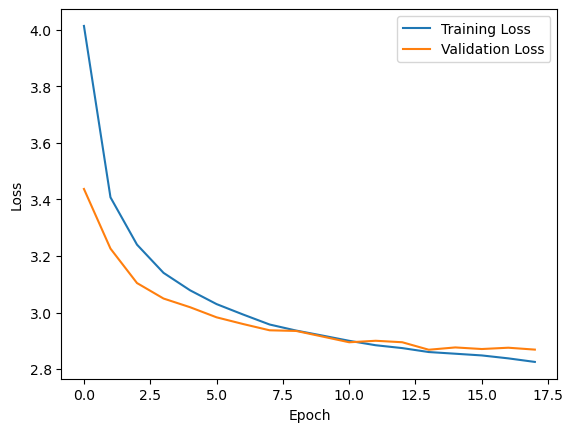

In [31]:
def load_json(filename):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        if not data:
            print(f"Warning: {filename} is empty.")
        return data
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filename}.")
        return None

# Load the loss values
train_loss_values = load_json('train_loss_values.json')
val_loss_values = load_json('val_loss_values.json')

# show thier values
train_loss_values ,val_loss_values

# Simplified plot without specifying figsize
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Testing phase
captioning_model.eval()
test_loss = 0
with torch.no_grad():
    for features, captions in test_loader:
        if features.shape[0] == 0:  # Skip empty batches
            continue
        # Move inputs and targets to the selected device (GPU or CPU)
        features = features.to(device)
        captions = captions.to(device)
                
        batch_size = features.size(0)  # Batch size (e.g., 32)
        num_captions = captions.size(1)  # Number of captions (e.g., 5)
        sequence_length = features.size(2)  # Sequence length (25)
        feature_size = features.size(3)  # Feature embedding size (256)

        # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
        features = features.squeeze(1)  # Removing the unnecessary singleton dimensions

        # Now expand the features to repeat them across the captions dimension
        features = features.unsqueeze(1).expand(-1, num_captions, -1, -1)  # [batch_size, num_captions, sequence_length, feature_size]

        # Flatten features for input into the model
        features = features.contiguous().view(batch_size * num_captions, sequence_length, feature_size)
        # Reshape captions as well
        captions = captions.view(batch_size * num_captions, -1)  # Make sure to handle caption shape accordingly

        # Forward pass
        outputs = captioning_model(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        test_loss += loss.item()

# Compute average test loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')


Test Loss: 2.8863517229373636


In [33]:
# Preprocess the image to match the expected input for the DETR model
def preprocess_image(image_path):
     # Instead of checking for string, print and check what's being passed
    print(f"Preprocessing image, path: {image_path}, type: {type(image_path)}")  
    if not isinstance(image_path, str):
        raise TypeError("image_path should be a string.")
    image = Image.open(image_path).convert('RGB')
    image = feature_extraction_transform(image)  # Apply your feature extraction transformation
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, H, W)
    return image
    
# Extract image features for the captioning model
def extract_image_features(image_path, model, device):
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        # Pass through the DETR model (it expects `pixel_values`)
        features = model(pixel_values=image_tensor).last_hidden_state  # Extract features
        features = features.view(features.size(0), -1)  # Flatten features
        features = features[:, :6400] 
    return features


In [34]:
def remove_repetitive_words(caption):
    """
    Removes consecutive repetitive words from the caption.
    """
    words = caption.split()
    filtered_words = [words[0]]  # Initialize with the first word
    
    for i in range(1, len(words)):
        if words[i] != words[i - 1]:
            filtered_words.append(words[i])
    
    return ' '.join(filtered_words)


def generate_caption(captioning_model, model, image_path, word_to_ix, ix_to_word, max_length,feature_size=feature_size, beam_size=5):
    """
    Generate a caption for an image using the trained captioning model and DETR Transformer for feature extraction.
    """
    
    print(f"Image Path: {image_path}")  # Debugging step
    if not isinstance(image_path, str):
        raise TypeError("image_path should be a valid string representing the file path.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Extract features from the image using the DETR model
    with torch.no_grad():
         # Preprocess the image and extract features
        features = extract_image_features(image_path, model, device)  # Shape is [1, 6400] now
        features = features.view(1, 6400)  # Ensure correct feature size
        print(f"Extracted feature shape: {features.shape}")

    # Initialize beam search with <START> token and a score of 0
    beam = [([word_to_ix['<START>']], 0)]  # (sequence, score)
    
    for _ in range(max_length):
        new_beam = []
        
        for seq, score in beam:
            caption_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)  # Convert sequence to tensor
            
            with torch.no_grad():
                outputs = captioning_model(features, caption_tensor)  # Forward pass through captioning model
            
            # Get top beam_size predictions for the next word
            top_k_scores, top_k_ids = torch.topk(outputs[0, -1], beam_size)
            
            # Iterate over top beam_size predictions
            for i in range(beam_size):
                new_seq = seq + [top_k_ids[i].item()]  # Append new word to sequence
                new_score = score + top_k_scores[i].item()  # Update score with log probability
                new_beam.append((new_seq, new_score))

        # Keep only the top beam_size sequences
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_size]
        
        # Stop if any sequence has generated the <END> token
        if any(seq[-1] == word_to_ix['<END>'] for seq, _ in beam):
            break

    # Choose the best sequence (the one with the highest score)
    best_seq = max(beam, key=lambda x: x[1])[0]

    # Skip the <START> and <END> tokens and convert the indices back to words
    caption = ' '.join([ix_to_word[ix] for ix in best_seq if ix not in [word_to_ix['<START>'], word_to_ix['<END>']]])

    # Remove repetitive words from the caption
    caption = remove_repetitive_words(caption)
    
    return caption


In [ ]:
import gc
# Path to the image you want to caption
image_path = 'dataset/Images/207275121_ee4dfa0bf2.jpg'
# Generate caption
feature_size = 6400
max_length = 30  # Maximum caption length

# try:
# Ensure synchronization before running the caption generation
torch.cuda.synchronize()

# Generate caption using preloaded models
caption = generate_caption(captioning_model, model, image_path, word_to_ix, ix_to_word, max_length, feature_size, beam_size=5)

# Load the image
image = Image.open(image_path)

# Convert image to numpy array
image_array = np.array(image)

# Create a new figure
fig, ax = plt.subplots()

# Plot the image and add the caption
ax.imshow(image_array)
ax.axis('off')  # Hide axes
ax.set_title(caption)

# Save the image with caption before showing it
fig.savefig('image_with_caption.png', bbox_inches='tight', pad_inches=0)  # Save the plot as a PNG file

# Display the image and the caption
plt.show()  # Ensure the image is displayed with the caption

# Free resources by clearing the figure
plt.close(fig)  # Close the current figure after saving the image

# Manually clear GPU cache and force garbage collection
torch.cuda.empty_cache()  # Clear the GPU cache
gc.collect()  # Force garbage collection to free RAM

# except Exception as e:
#     print(f"Error during caption generation: {e}")

In [ ]:
caption

In [37]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import fractions

# Custom fraction class to avoid the unexpected keyword argument '_normalize' issue
class CustomFraction(fractions.Fraction):
    def __new__(cls, numerator=0, denominator=None, _normalize=True):
        return super().__new__(cls, numerator, denominator)

# Override the modified_precision function in nltk
import nltk.translate.bleu_score as bleu_score
bleu_score.Fraction = CustomFraction

# Testing phase with BLEU score calculation and tqdm progress bar
captioning_model.eval()
test_loss = 0
bleu_scores = []
smoothing_function = SmoothingFunction().method4

# Lists to collect actual and predicted captions for BLEU score calculation
actual_captions = []
predicted_captions_list = []

# Use tqdm to track the progress of the testing phase
with torch.no_grad():
    for features, captions in tqdm(test_loader, desc="Testing"):
        if features.shape[0] == 0:
            continue
        features = features.to(device)
        captions = captions.to(device)
        batch_size = features.size(0)  # Batch size (e.g., 32)
        num_captions = captions.size(1)  # Number of captions (e.g., 5)
        sequence_length = features.size(2)  # Sequence length (25)
        feature_size = features.size(3)  # Feature embedding size (256)

        # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
        features = features.squeeze(1)  # Removing the unnecessary singleton dimensions

        # Now expand the features to repeat them across the captions dimension
        features = features.unsqueeze(1).expand(-1, num_captions, -1, -1)  # [batch_size, num_captions, sequence_length, feature_size]

        # Flatten features for input into the model
        features = features.contiguous().view(batch_size * num_captions, sequence_length, feature_size)
        # Reshape captions as well
        captions = captions.view(batch_size * num_captions, -1)  # Make sure to handle caption shape accordingly

        # Forward pass
        outputs = captioning_model(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        test_loss += loss.item()

        # Decode the outputs and collect captions
        predicted_captions = outputs.argmax(2).cpu().numpy()
        for pred, actual in zip(predicted_captions, captions.cpu().numpy()):
            pred_caption = [ix_to_word[ix] for ix in pred if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            actual_caption = [ix_to_word[ix] for ix in actual if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            actual_captions.append(actual_caption)
            predicted_captions_list.append(pred_caption)

# Calculate BLEU scores for all captions
bleu1 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
bleu2 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
bleu3 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
bleu4 = corpus_bleu([[actual] for actual in actual_captions], predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

# Calculate average loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')
print(f'BLEU-1 Score: {bleu1}')
print(f'BLEU-2 Score: {bleu2}')
print(f'BLEU-3 Score: {bleu3}')
print(f'BLEU-4 Score: {bleu4}')


Testing: 100%|██████████| 26/26 [00:01<00:00, 16.85it/s]


Test Loss: 2.8863517229373636
BLEU-1 Score: 0.36587084078780974
BLEU-2 Score: 0.22793517375361835
BLEU-3 Score: 0.16567726853269638
BLEU-4 Score: 0.1139180228254251


In [38]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import fractions

# Custom fraction class to avoid the unexpected keyword argument '_normalize' issue
class CustomFraction(fractions.Fraction):
    def __new__(cls, numerator=0, denominator=None, _normalize=True):
        return super().__new__(cls, numerator, denominator)

# Override the modified_precision function in nltk
import nltk.translate.bleu_score as bleu_score
bleu_score.Fraction = CustomFraction

# Testing phase with BLEU score calculation and tqdm progress bar
captioning_model.eval()
test_loss = 0
bleu_scores = []
smoothing_function = SmoothingFunction().method4

# Use tqdm to track the progress of the testing phase
with torch.no_grad():
    for features, captions in tqdm(test_loader, desc="Testing"):
        if features.shape[0] == 0:
            continue
        # Move inputs and targets to the selected device (GPU or CPU)
        features = features.to(device)
        captions = captions.to(device)
                
        batch_size = features.size(0)  # Batch size (e.g., 32)
        num_captions = captions.size(1)  # Number of captions (e.g., 5)
        sequence_length = features.size(2)  # Sequence length (25)
        feature_size = features.size(3)  # Feature embedding size (256)

        # Squeeze out the extra dimensions in `features` to make it [batch_size, feature_size]
        features = features.squeeze(1)  # Removing the unnecessary singleton dimensions

        # Now expand the features to repeat them across the captions dimension
        features = features.unsqueeze(1).expand(-1, num_captions, -1, -1)  # [batch_size, num_captions, sequence_length, feature_size]

        # Flatten features for input into the model
        features = features.contiguous().view(batch_size * num_captions, sequence_length, feature_size)
        # Reshape captions as well
        captions = captions.view(batch_size * num_captions, -1)  # Make sure to handle caption shape accordingly

        # Forward pass
        outputs = captioning_model(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        test_loss += loss.item()

        # Decode the outputs and calculate BLEU scores
        predicted_captions = outputs.argmax(2).cpu().numpy()
        for pred, actual in zip(predicted_captions, captions.cpu().numpy()):
            pred_caption = [ix_to_word[ix] for ix in pred if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            actual_caption = [ix_to_word[ix] for ix in actual if ix not in {word_to_ix['<PAD>'], word_to_ix['<START>'], word_to_ix['<END>'], word_to_ix['<UNK>']}]
            bleu_score_value = sentence_bleu([actual_caption], pred_caption, smoothing_function=smoothing_function)
            bleu_scores.append(bleu_score_value)

# Calculate average loss and BLEU score
test_loss /= len(test_loader)
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f'Test Loss: {test_loss}')
print(f'Average BLEU Score: {average_bleu_score}')


Testing: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s]

Test Loss: 2.8863517229373636
Average BLEU Score: 0.16445025920032783
